### Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import StackingRegressor
import scipy.stats as stats
import xgboost as xgb

### Uploading data

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
full_df = pd.concat([train_df, test_df], sort=False)
id_ = full_df['Id']
y = np.log1p(train_df['SalePrice'])
full_df.drop(['Id', 'SalePrice'], axis=1, inplace=True)

### Viewing data

In [7]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Data visualization

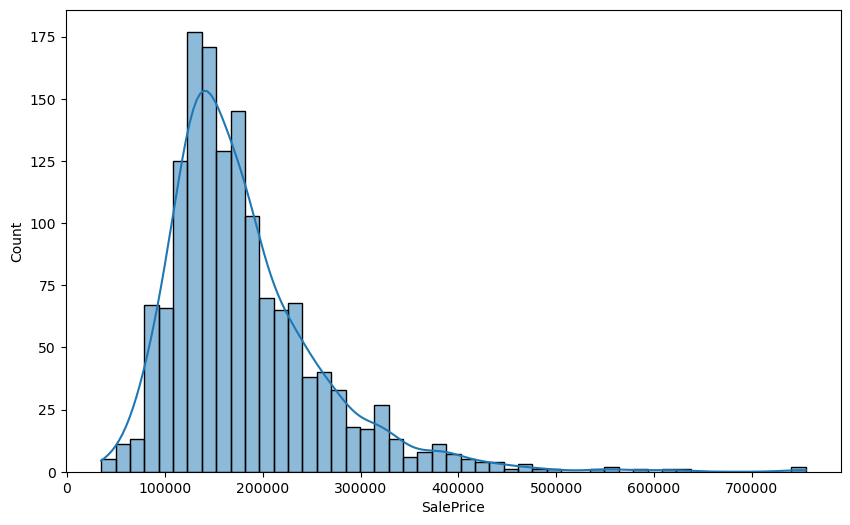

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.show()

In [10]:
train_df_copy = train_df.drop('Id', axis=1)

In [11]:
hist_df = train_df_copy.select_dtypes(include = ['float64', 'int64'])

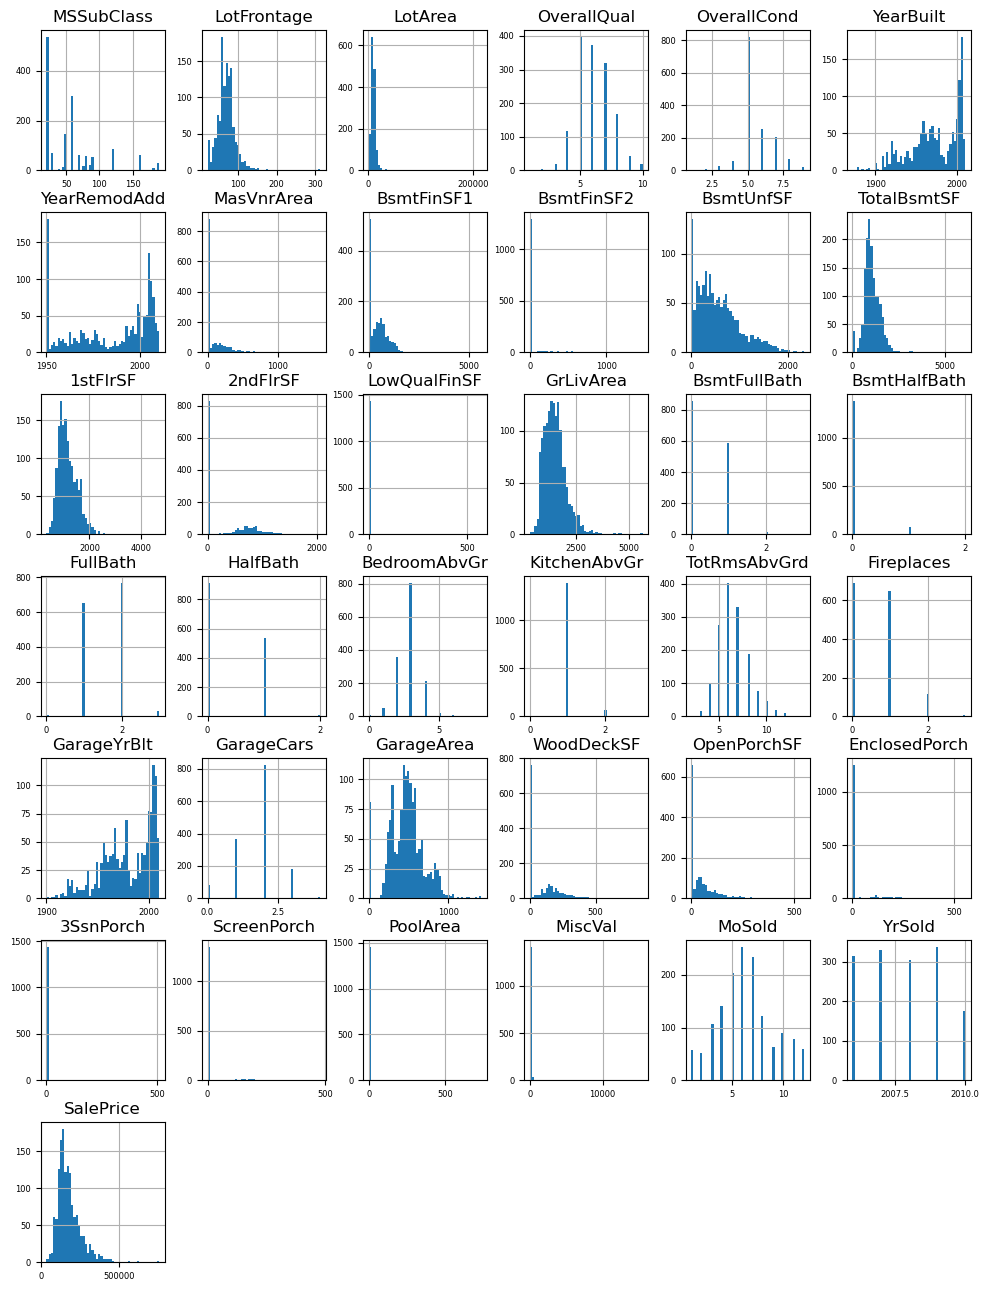

In [12]:
hist_df.hist(figsize=(12, 16), xlabelsize=6, ylabelsize=6,bins=50);

### Creating new features

In [13]:
def custom_features(df):
    df['LivingSpace'] = df[['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF']].sum(axis=1)
    df['PoolAvailable'] = (df['PoolArea'] > 0).astype(int)
    df['PorchAreaTotal'] = df[['OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch']].sum(axis=1)
    df['BuildingArea'] = df[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']].sum(axis=1)
    df['GarageAvailable'] = (df['GarageArea'] > 0).astype(int) 
    df['BasementAvailable'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['BuildRemodYear'] = df['YearBuilt'] + df['YearRemodAdd']   
    df['FireplaceAvailable'] = (df['Fireplaces'] > 0).astype(int)
    df['SecondFloorAvailable'] = (df['2ndFlrSF'] > 0).astype(int)
    df['TotalBaths'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    return df

In [14]:
full_df = custom_features(full_df)

### Distribution graphs for key features

In [17]:
full_df_copy = full_df.reset_index(drop=True)

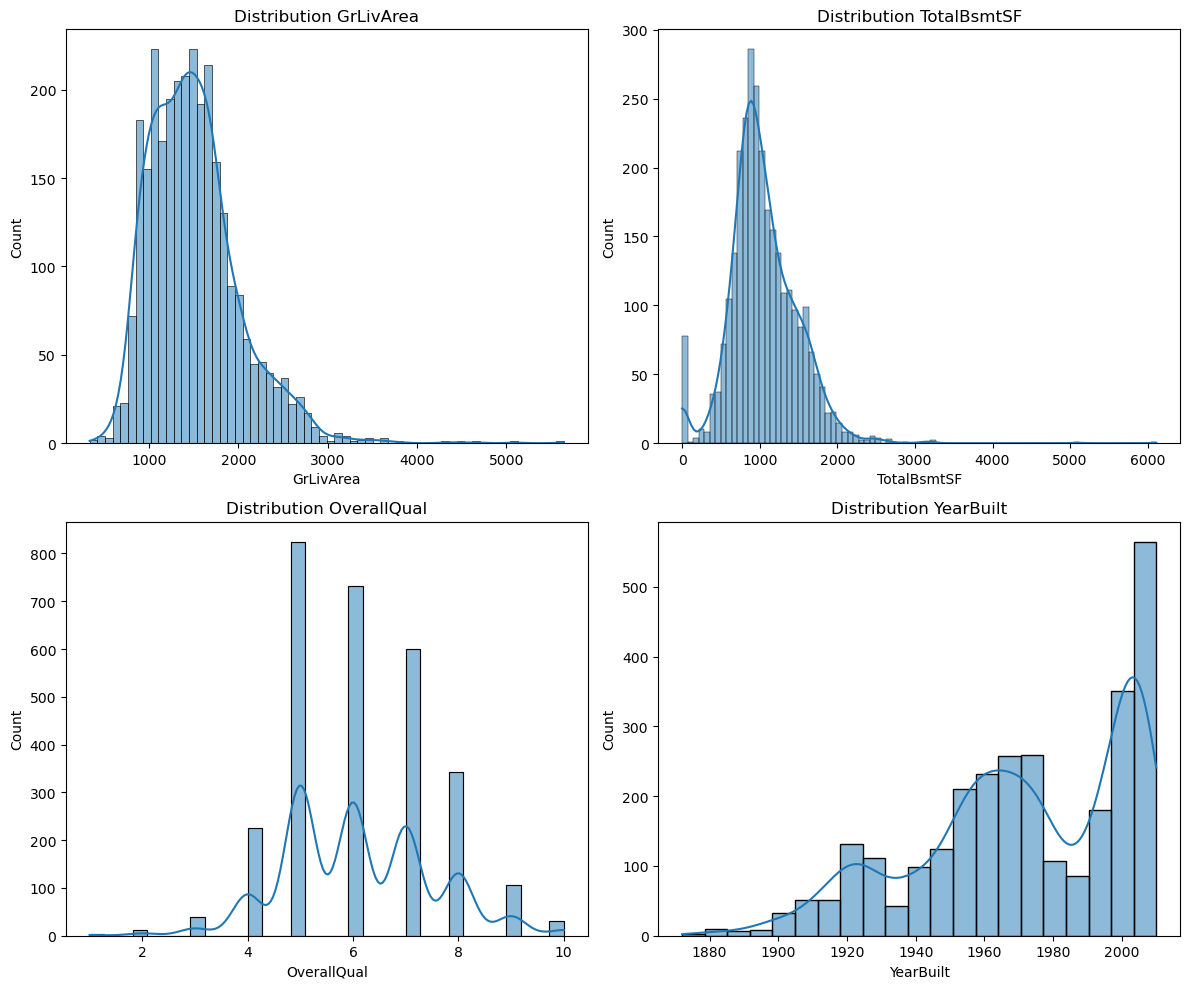

In [18]:
key_features = ['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'YearBuilt']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, feature in enumerate(key_features):
    sns.histplot(data=full_df_copy, x=feature, kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution {feature}')
plt.tight_layout()
plt.show()

### Functions for missing values

In [20]:
def percent_missing(df):
    total = 100 *df.isnull().sum() / len(df)
    total = total[total > 0].sort_values(ascending=False)
    return total

In [21]:
def preprocess(df):
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.mean()) 
    
    for column in df.select_dtypes(exclude='number').columns:
        df[column] = df[column].fillna('None')
    
    for column in df.select_dtypes(include='number').columns:
        df[column] = df[column].fillna(0)
    
    return df

### Deduction of the percentage of missing data

In [22]:
percent_nan = percent_missing(full_df)
percent_nan

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
MasVnrType      60.500171
FireplaceQu     48.646797
LotFrontage     16.649538
GarageCond       5.447071
GarageYrBlt      5.447071
GarageFinish     5.447071
GarageQual       5.447071
GarageType       5.378554
BsmtExposure     2.809181
BsmtCond         2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrArea       0.787941
MSZoning         0.137033
Functional       0.068517
TotalBaths       0.068517
BsmtHalfBath     0.068517
BsmtFullBath     0.068517
Utilities        0.068517
KitchenQual      0.034258
TotalBsmtSF      0.034258
BsmtUnfSF        0.034258
GarageCars       0.034258
GarageArea       0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
SaleType         0.034258
Electrical       0.034258
dtype: float64

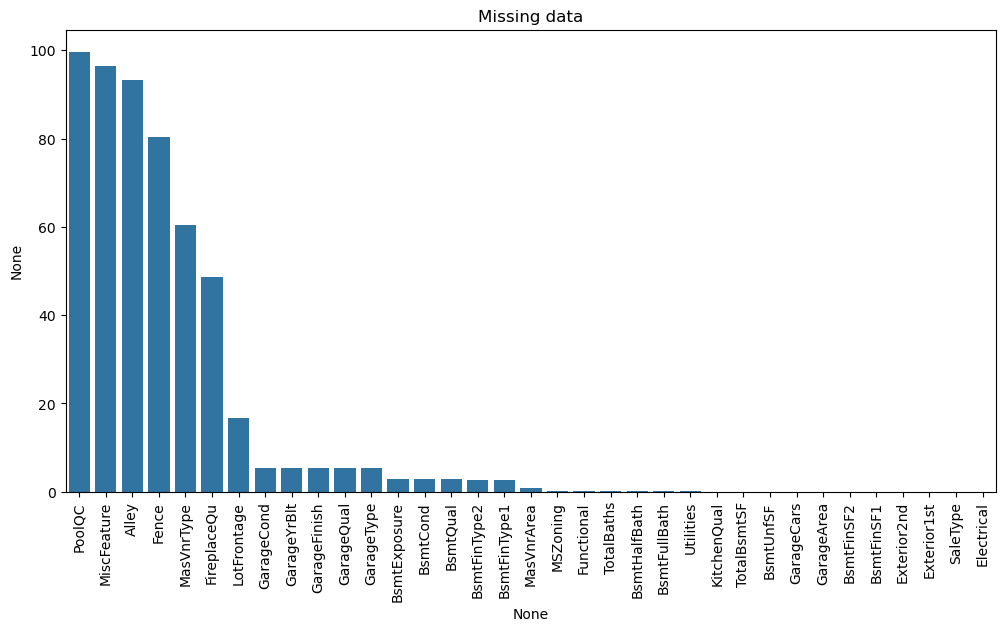

In [23]:
missing_data = percent_missing(full_df)
plt.figure(figsize=(12,6))
sns.barplot(x=missing_data.index, y=missing_data)
plt.xticks(rotation=90)
plt.title('Missing data')
plt.savefig('missingdata.png', dpi=300, bbox_inches='tight')
plt.show()

### Processing of missing values

In [24]:
full_df = preprocess(full_df)

In [25]:
percent_nan = percent_missing(full_df)
percent_nan

Series([], dtype: float64)

### Application Of One Hot Encoding

In [26]:
def encode(df):
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    categorical_columns = list(df.select_dtypes(exclude='number').columns)
    numeric_columns = list(df.select_dtypes(include='number').columns)
    transformed_values = encoder.fit_transform(df[categorical_columns])
    transformed_columns = list(encoder.get_feature_names_out())
    df[transformed_columns] = transformed_values
    
    return df[transformed_columns + numeric_columns]

In [27]:
full_df = encode(full_df)

In [28]:
full_df.head(5)

,MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_None,Alley_Pave,LotShape_IR2,LotShape_IR3,...,LivingSpace,PoolAvailable,PorchAreaTotal,BuildingArea,GarageAvailable,BasementAvailable,BuildRemodYear,FireplaceAvailable,SecondFloorAvailable,TotalBaths
0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2416.0,0,61,2566.0,1,1,4006,0,1,3.5
1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2240.0,0,0,2524.0,1,1,3952,1,0,2.5
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2272.0,0,42,2706.0,1,1,4003,1,1,3.5
3,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1933.0,0,307,2473.0,1,1,3885,1,1,2.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2853.0,0,84,3343.0,1,1,4000,1,1,3.5


### Preparation before training

In [30]:
X = full_df.iloc[:len(train_df)]
test = full_df.iloc[len(train_df):]

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Creating a model

In [32]:
xgb_model = xgb.XGBRegressor( # gridsearchcv was used to find these values
    learning_rate=0.009, 
    n_estimators=3600,
    max_depth=4, 
    min_child_weight=2,
    subsample=0.41,
    colsample_bytree=0.21,
    reg_alpha=0.35,
    reg_lambda=0.045,
    objective='reg:squarederror',
    nthread=-1,
    random_state=1
)

In [33]:
ridge_model = Ridge(alpha=15) # according to the results, ridge is better than lasso

In [34]:
stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('ridge', ridge_model)
    ],
    final_estimator=LinearRegression(),
    cv=10
)

### The effect of logarithm on data distribution.

In [35]:
original_data = train_df['SalePrice']
log_data = np.log1p(train_df['SalePrice'])

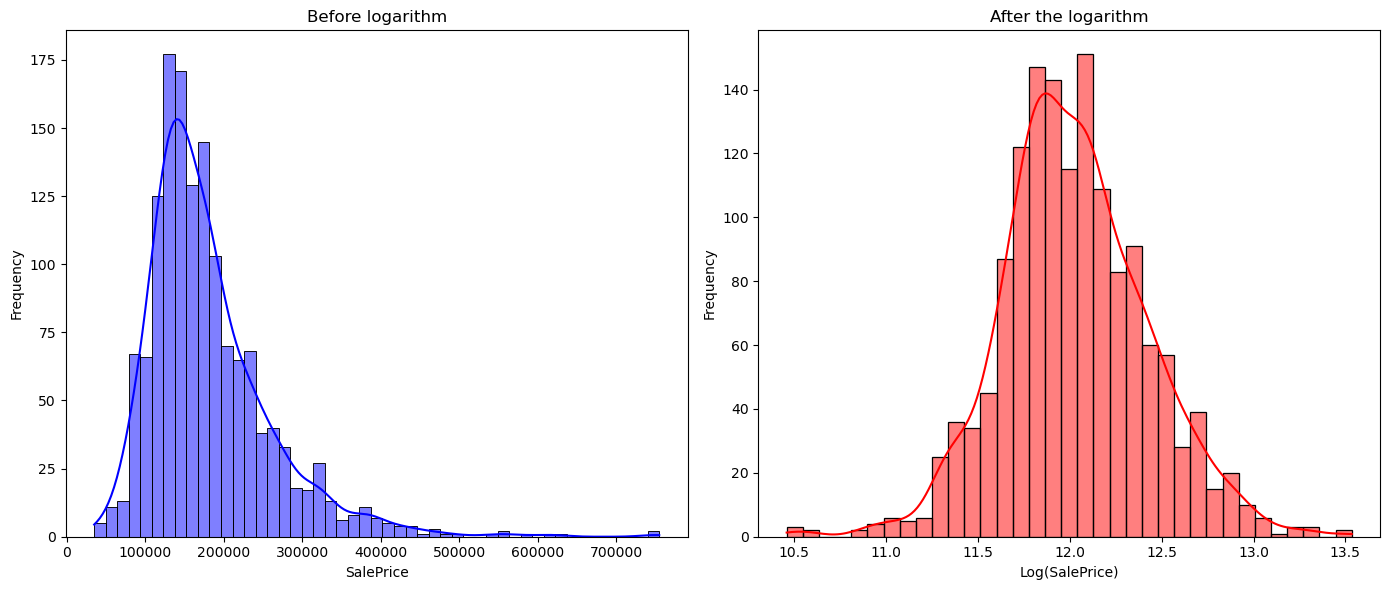

In [36]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(original_data, kde=True, color='blue')
plt.title('Before logarithm')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(log_data, kde=True, color='red')
plt.title('After the logarithm')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Model training

In [37]:
stack_model.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.21, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.009, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None, min_child_weight=2,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=3600, n_jobs=None,
                                            nthread=-1, num_parallel_tree=None, ...)),
                              ('ridge', Ridge(alpha=15))],
                  final_estimator=LinearRegression())

In [38]:
y_pred = stack_model.predict(X_val)

### Evaluation of the model

In [39]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print(f"\nRMSE: {rmse}")
print(f"R²: {r2}")


RMSE: 0.12939706344820454
R²: 0.9102753800533543


### Plotting balance graph

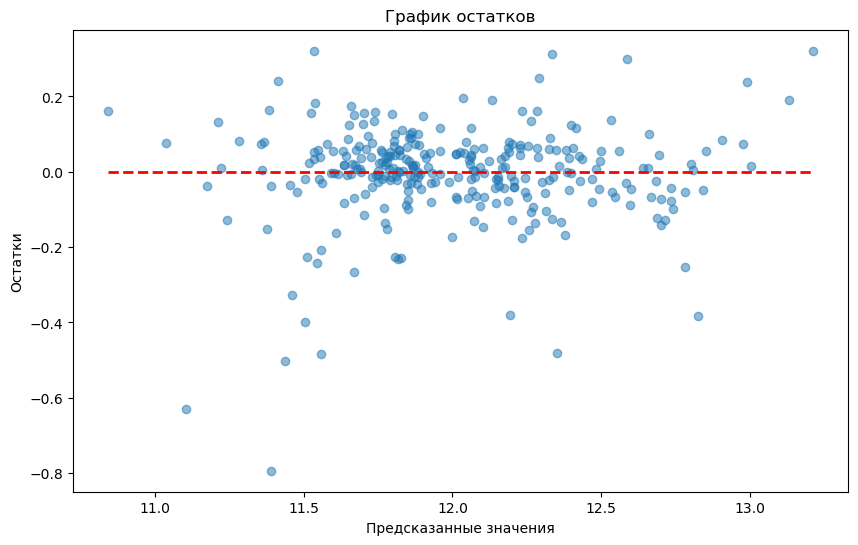

In [40]:
residuals = y_val - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'r--', lw=2)
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

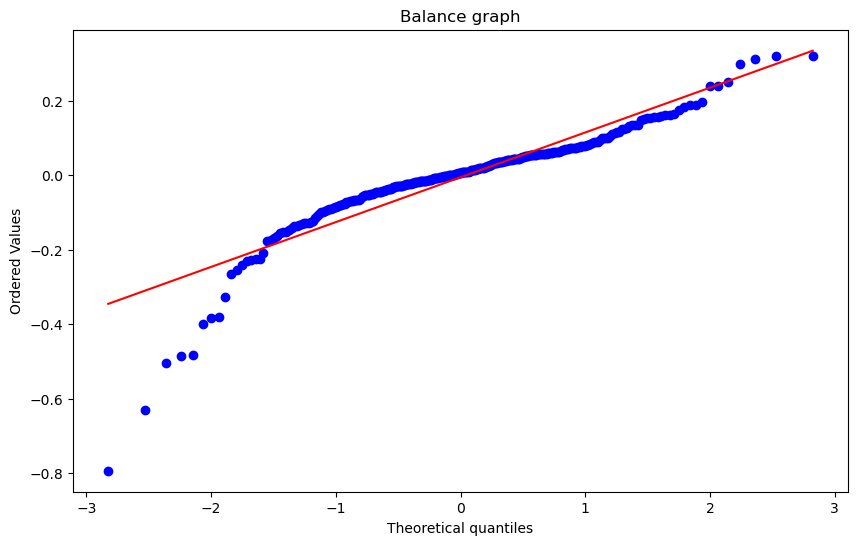

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Balance graph")
plt.show()

### Model prediction

In [42]:
test_pred = np.expm1(stack_model.predict(test))

In [43]:
output = pd.DataFrame({
    'Id': id_[len(train_df):],
    'SalePrice': test_pred
})

### Saving the results

In [44]:
output.to_csv('submission.csv' ,index=False)

## Kaggle score:
**Top 5% scoring: 0.11996**

**RMSE: 0.057795021594590885**

**R²: 0.9790513927912862**